<a href="https://colab.research.google.com/github/arunoda/fastai-v4/blob/master/06_1_multi_cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi Category Model using fast.ai**

Here we are trying to create a model for a dataset where an individual image could related to one or more categories.

Let's see how it goes.

## Setting Up on Colab

You only need to run this on Colab.

In [2]:
!pip install fastai2
!git clone https://github.com/arunoda/fastai-v4
%cd fastai-v4
!pwd

     |████████████████████████████████| 194kB 5.4MB/s 
Cloning into 'fastai-v4'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 111 (delta 43), reused 48 (delta 12), pack-reused 22
Receiving objects: 100% (111/111), 127.46 MiB | 29.18 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/fastai-v4
/content/fastai-v4


In [0]:
from fastai2.vision.all import *

## Dataset

Here we will use a dataset called PASCAL. Let's inspect it.

In [4]:
dataset = untar_data(URLs.PASCAL_2007)
dataset.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/segmentation')]

In [5]:
train_image_list = (dataset/"train").ls()
train_image_list

(#5012) [Path('/root/.fastai/data/pascal_2007/train/002735.jpg'),Path('/root/.fastai/data/pascal_2007/train/004873.jpg'),Path('/root/.fastai/data/pascal_2007/train/009422.jpg'),Path('/root/.fastai/data/pascal_2007/train/003280.jpg'),Path('/root/.fastai/data/pascal_2007/train/005586.jpg'),Path('/root/.fastai/data/pascal_2007/train/006472.jpg'),Path('/root/.fastai/data/pascal_2007/train/002146.jpg'),Path('/root/.fastai/data/pascal_2007/train/004611.jpg'),Path('/root/.fastai/data/pascal_2007/train/009887.jpg'),Path('/root/.fastai/data/pascal_2007/train/006449.jpg')...]

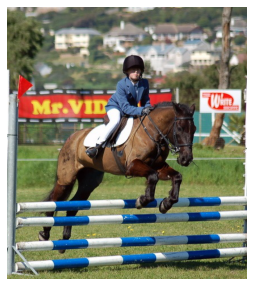

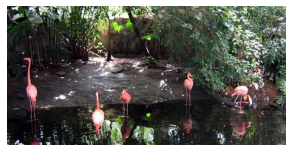

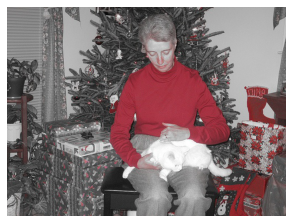

In [6]:
show_image(Image.open(train_image_list[0]))
show_image(Image.open(train_image_list[100]))
show_image(Image.open(train_image_list[200]))

**It seems like this is a dataset of a mix of different stuff**

In [7]:
!head {dataset/"train.csv"}

fname,labels,is_valid
000005.jpg,chair,True
000007.jpg,car,True
000009.jpg,horse person,True
000012.jpg,car,False
000016.jpg,bicycle,True
000017.jpg,person horse,False
000019.jpg,cat,True
000020.jpg,car,True
000021.jpg,dog person,True


Okay. This csv file contains everything.

It seems like they have already provid validation set here in the train dataset.
<br/>

I think there's something call test.csv, which will be the final test dataset.

Let's inspect that too.

In [8]:
!head {dataset/"test.csv"}

fname,labels
000001.jpg,dog person
000002.jpg,train
000003.jpg,sofa chair
000004.jpg,car
000006.jpg,pottedplant diningtable chair
000008.jpg,chair
000010.jpg,horse person
000011.jpg,cat
000013.jpg,cow


Yep. We are correct. It does not have isValid field.

## Inspecting Images with the train.csv

Here we need to load these images using the `train.csv` file.

In [0]:
df_train = pd.read_csv(dataset/"train.csv")

In [10]:
df_train.describe()

,fname,labels,is_valid
count,5011,5011,5011
unique,5011,473,2
top,007074.jpg,person,True
freq,1,408,2510


In [11]:
df_train.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [12]:
df_train.loc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [13]:
df_train.loc[0].fname, df_train.loc[0]['fname'] 

('000005.jpg', '000005.jpg')

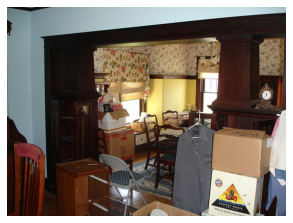

In [14]:
show_image(Image.open(dataset/"train"/df_train.loc[0]['fname']))

## Loading images

Let's load these images using the datablock API.

In [0]:
def get_x(row):
  return dataset/"train"/row['fname']

def get_y(row):
  return row['labels'].split(' ')

def splitter(df):
  train_ids = df.index[df['is_valid'] == False].tolist()
  valid_ids = df.index[df['is_valid'] == True].tolist()

  return train_ids, valid_ids

db = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x = get_x,
    get_y = get_y,
    splitter = splitter,
    item_tfms = RandomResizedCrop(224, min_scale=0.35)
)

In [0]:
dsets = db.datasets(df_train)

In [0]:
x, y = dsets.train[0]

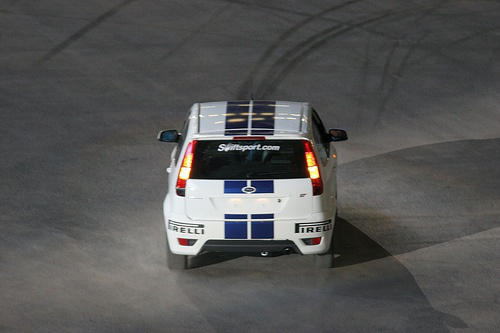

In [18]:
x

In [19]:
y

TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [20]:
dsets.vocab

(#20) ['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow'...]

In [0]:
dls = db.dataloaders(df_train)

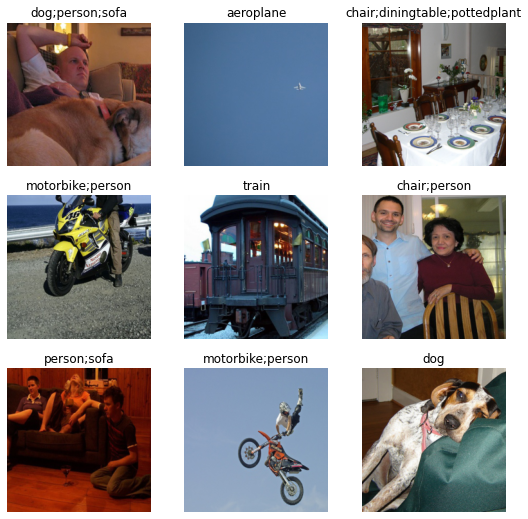

In [34]:
dls.show_batch()

## Creating the Model

In [0]:
learn = cnn_learner(dls, resnet34, metrics=accuracy_multi)

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.033113110810518265)

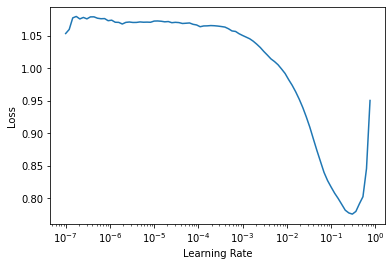

In [36]:
learn.lr_find()

In [37]:
learn.fine_tune(4, base_lr=1e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.643254,0.134923,0.957072,00:35


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.133753,0.115749,0.959701,00:36
1,0.117109,0.111109,0.962570,00:36
2,0.096545,0.094823,0.966614,00:36
3,0.076533,0.090061,0.968167,00:36


**Result is not bad**

Tried reset18 with 112 as the pixel size. It'll negatively, impact the perf.

Epoch time reduce by 5 secs.

So, we get rid of that optimization.

## Anlyzing the model

In [38]:
analyzer = ClassificationInterpretation.from_learner(learn)

,target,predicted,probabilities,loss
0,boat;person,pottedplant,"tensor([3.7422e-05, 3.1009e-04, 1.2000e-04, 1.2047e-02, 4.6776e-04, 7.5033e-05,\n 1.6697e-03, 5.2579e-04, 4.0036e-02, 1.7518e-05, 8.8166e-03, 3.1262e-04,\n 4.4655e-05, 6.1106e-04, 3.6994e-03, 9.8525e-01, 5.4893e-05, 3.2206e-03,\n 6.0107e-05, 9.3707e-04])",0.7146478295326233
1,horse;person,bicycle;chair,"tensor([7.5303e-04, 6.9044e-01, 6.3106e-04, 4.6137e-04, 2.1061e-02, 2.3022e-02,\n 8.6491e-03, 1.6449e-03, 7.7467e-01, 1.5183e-03, 2.3014e-01, 8.3458e-03,\n 9.9195e-04, 2.6161e-03, 2.5929e-02, 4.5662e-02, 6.1422e-04, 5.7728e-02,\n 2.7854e-03, 1.4324e-02])",0.6842924952507019
2,horse;person,pottedplant,"tensor([2.0865e-04, 1.1801e-02, 2.4044e-02, 1.5390e-03, 1.9000e-03, 2.9113e-03,\n 3.1225e-03, 1.0136e-03, 1.6442e-02, 2.2211e-04, 2.3956e-03, 1.2724e-03,\n 1.4433e-03, 2.5571e-03, 2.9939e-03, 6.1578e-01, 1.1969e-03, 9.4995e-04,\n 3.3846e-04, 1.1661e-03])",0.6691054701805115
3,bottle;chair;pottedplant;sofa;tvmonitor,chair;diningtable,"tensor([1.1129e-04, 2.1586e-03, 4.5020e-04, 1.7941e-04, 8.8192e-03, 1.3395e-04,\n 9.7618e-04, 8.7766e-04, 9.9719e-01, 3.2526e-04, 8.4584e-01, 4.3400e-03,\n 9.4942e-04, 2.5084e-04, 1.8191e-01, 1.8335e-01, 2.1020e-04, 3.8575e-01,\n 3.1408e-04, 3.4399e-02])",0.6417071223258972
4,chair;diningtable;person,car;person,"tensor([0.0016, 0.0197, 0.0012, 0.0114, 0.0014, 0.1807, 0.5208, 0.0010, 0.0100,\n 0.0024, 0.0015, 0.0036, 0.0048, 0.1829, 0.9098, 0.0106, 0.0012, 0.0014,\n 0.1010, 0.0019])",0.6247825026512146
5,car;person;tvmonitor,car,"tensor([1.1228e-05, 4.8138e-04, 2.4808e-05, 6.4531e-04, 1.7075e-04, 1.7289e-05,\n 9.9999e-01, 1.3754e-05, 1.2451e-03, 9.8245e-05, 3.2569e-05, 3.5008e-05,\n 1.4533e-05, 2.7702e-04, 1.0173e-01, 3.4240e-03, 1.6248e-04, 3.7513e-04,\n 3.3414e-04, 4.9021e-05])",0.6108025908470154
6,dog,bird,"tensor([1.2688e-04, 3.5281e-04, 9.9757e-01, 3.2408e-04, 2.8155e-03, 1.7993e-04,\n 8.7239e-04, 1.1167e-03, 1.0419e-03, 2.9716e-04, 6.8146e-04, 2.3302e-03,\n 8.6828e-05, 1.1362e-04, 1.1946e-02, 1.1066e-02, 5.4172e-05, 2.1220e-04,\n 3.8546e-05, 6.5011e-04])",0.6056999564170837
7,cat;chair;person;sofa,person,"tensor([6.7216e-03, 6.0832e-02, 3.5990e-03, 8.5888e-04, 5.7782e-02, 1.5398e-02,\n 1.5725e-01, 7.2359e-03, 5.2323e-02, 7.8356e-04, 1.5406e-03, 3.4644e-02,\n 7.4094e-02, 1.7298e-03, 8.6286e-01, 1.2043e-01, 1.7424e-03, 4.4255e-02,\n 1.8125e-03, 3.2788e-02])",0.5872955322265625
8,bus;person;train,train,"tensor([1.8405e-05, 1.4162e-04, 1.3254e-04, 5.1966e-05, 6.6148e-05, 1.2339e-04,\n 2.4783e-02, 9.5569e-05, 5.5107e-04, 3.4794e-05, 3.6622e-05, 8.7588e-04,\n 1.7700e-03, 2.4627e-04, 8.0004e-02, 4.9705e-03, 1.1594e-04, 1.9973e-04,\n 9.9966e-01, 1.1811e-03])",0.5780872702598572


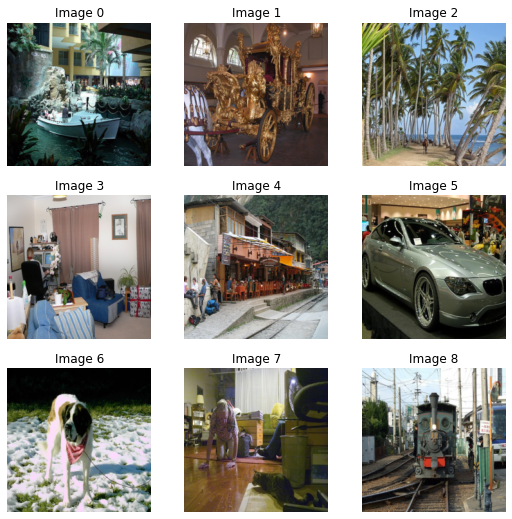

In [44]:
analyzer.plot_top_losses(9)

## Image Cleaning

In [0]:
from fastai2.vision.widgets import *

In [46]:
cleaner = ImageClassifierCleaner(learn)

In [49]:
cleaner

**Hmm. Seems like it does not work well**